# PDBe API Training

This interactive Python notebook will guide you through various ways of programmatically accessing Protein Data Bank in Europe (PDBe) data using REST API

The REST API is a programmatic way to obtain information from the PDB and EMDB. You can access details about:

* sample
* experiment
* models
* compounds
* cross-references
* publications
* quality
* assemblies
and more...
For more information, visit https://www.ebi.ac.uk/pdbe/pdbe-rest-api

# Notebook #6
This notebook is the second in the training material series, and focuses on getting information for multiple PDB entries using the REST search API of PDBe.

## 1) Making imports and setting variables
First, we import some packages that we will use, and set some variables.

Note: Full list of valid URLs is available from https://www.ebi.ac.uk/pdbe/api/doc/

In [136]:
import requests # used for getting data from a URL
from pprint import pprint # pretty print
import matplotlib.pyplot as plt # plotting results

get_ipython().run_line_magic('matplotlib', 'inline') # allowing in-line plots

base_url = "https://www.ebi.ac.uk/pdbe/" # the beginning of the URL for PDBe's API.

api_base = base_url + "api/"

search_url = base_url + 'search/pdb/select?' # the rest of the URL used for PDBe's search API. 

## 2) a function to get data from the search API
Let's start with defining a function that can be used to GET data from the PDBe search API.


In [137]:
def make_request(search_term, number_of_rows=10):
    """
    This function can make GET requests to
    the PDBe search API
    
    :param url: String,
    :param pdb_id: String
    :return: JSON
    """
    search_variables = '&wt=json&rows={}'.format(number_of_rows)
    url = search_url+search_term+search_variables
    print(url)
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print("[No data retrieved - %s] %s" % (response.status_code, response.text))
    
    return {}

## 3) formatting the search terms 
This will allow us to use human readable search terms and this function will make a URL that the search API can handle.

In [138]:
def format_search_terms(search_terms, filter_terms=None):
    # print('formatting search terms: %s' % search_terms)
    search_string = ''
    filter_string = ''
    search_list = []
    if isinstance(search_terms, dict):
        for key in search_terms:
            term = search_terms.get(key)
            if ' ' in term:
                if not '"' in term:
                    term = '"{}"'.format(term)
                elif not "'" in term:
                    term = "'{}'".format(term)
            search_list.append('{}:{}'.format(key, term))
        search_string = ' AND '.join(search_list)
    else:
        if '&' in search_terms:
            search_string = search_terms.replace('&', ' AND ')
        else:
            search_string = search_terms
    if filter_terms:
        filter_string = '&fl={}'.format(','.join(filter_terms))
    # print('formatted search terms: %s' % search_string)
    final_search_string = 'q={}{}'.format(search_string, filter_string)
    return final_search_string

## 4) Getting useful data out of the search

This function will run the search and will return a list of the results

In [139]:
def run_search(search_terms, filter_terms=None, number_of_rows=10):
    search_term = format_search_terms(search_terms, filter_terms)

    response = make_request(search_term, number_of_rows)
    return response.get('response', {}).get('docs', [])
    

## 5) running a search

Now we are ready to actually run a search against the PDB API for entries containing human Dihydrofolate reductase in the PDB. This will return a list of results - only 10 to start with.

A list of search terms is available at:
https://www.ebi.ac.uk/pdbe/api/doc/search

This will return details of human Dihydrofolate reductase's in the PDB

The search terms are defined as a dictionary (a hash in other programming lanuguages). 
e.g. 
{"molecule_name":"Dihydrofolate reductase"}
Here we are searching for molecules named Dihydrofolate reductase.
If we search for two terms i.e. molecule_name and organism_scientific_name then we will get molecules that match both search terms.

It will return the number of results for two searches.

In [140]:
print('1st search')
search_terms = {"molecule_name":"Dihydrofolate reductase"} 

results = run_search(search_terms)
print('Number of results for {}: {}'.format(','.join(search_terms.values()), len(results)))

1st search
https://www.ebi.ac.uk/pdbe/search/pdb/select?q=molecule_name:"Dihydrofolate reductase"&wt=json&rows=10
Number of results for Dihydrofolate reductase: 10


In [141]:
print('2nd search')
search_terms = {"molecule_name":"Dihydrofolate reductase",
                "organism_name":"Human"
               } 
results = run_search(search_terms)
print('Number of results for {}: {}'.format(','.join(search_terms.values()), len(results)))

2nd search
https://www.ebi.ac.uk/pdbe/search/pdb/select?q=molecule_name:"Dihydrofolate reductase" AND organism_name:Human&wt=json&rows=10
Number of results for Dihydrofolate reductase,Human: 10


We will then look at the last result.
We will print the data we have for the first result.

This will be the first item of the list "results"
i.e. results[0]

We are using "pprint" (pretty print) rather than "print" to make the result easier to read.

In [142]:
pprint(results[0])

{'_version_': 1640913511922008064,
 'all_assembly_composition': ['protein structure'],
 'all_assembly_form': ['homo'],
 'all_assembly_id': ['1'],
 'all_assembly_mol_wt': [22.798],
 'all_assembly_type': ['monomer'],
 'all_authors': ['Cody V', 'Gangjee A'],
 'all_compound_names': ['NDP : NADPH DIHYDRO-NICOTINAMIDE-ADENINE-DINUCLEOTIDE '
                        'PHOSPHATE',
                        '63Y : '
                        '5-methyl-6-[(2,3,4-trifluorophenyl)sulfanyl]thieno[2,3-d]pyrimidine-2,4-diamine',
                        '63Y : '
                        '5-methyl-6-[(2,3,4-trifluorophenyl)sulfanyl]thieno[2,3-d]pyrimidine-2,4-diamine',
                        '63Y : '
                        '5-methyl-6-[2,3,4-tris(fluoranyl)phenyl]sulfanyl-thieno[2,3-d]pyrimidine-2,4-diamine',
                        'NDP : '
                        '[[(2R,3S,4R,5R)-5-(3-aminocarbonyl-4H-pyridin-1-yl)-3,4-dihydroxy-oxolan-2-yl]methoxy-hydroxy-phosphoryl] '
                        '[(2R,3R,4R

                  'regulatory element binding',
                  'GO:0008144 : drug binding',
                  'GO:0005737 : cytoplasm',
                  'GO:0005739 : mitochondrion',
                  'GO:0005829 : cytosol'],
 'q_has_bound_molecule': 'Y',
 'q_has_modified_residues': 'N',
 'q_homologus_pdb_entity_id': ['4qhv_1',
                               '6dav_1',
                               '1dlr_1',
                               '4kak_1',
                               '4keb_1',
                               '5hqy_1',
                               '5hqz_1',
                               '1u72_1',
                               '2w3b_1',
                               '5hsr_1',
                               '5ht4_1',
                               '3nu0_1',
                               '3nxo_1',
                               '3nxt_1',
                               '3nxv_1',
                               '2c2s_1',
                               '3nxr_1',
          

 'seq_95_cluster_rank': 41,
 'spacegroup': 'H 3',
 'status': 'REL',
 'struct_asym_id': ['A'],
 'structure_determination_method': ['MOLECULAR REPLACEMENT'],
 'structure_solution_software': ['MOLREP'],
 'superkingdom': ['Eukaryota'],
 'synchrotron_beamline': ['BL14-1'],
 'synchrotron_site': ['SSRL'],
 't_all_compound_names': ['Nicotinamide-adenine dinucleotide',
                          'NDP',
                          'NDP : NADPH '
                          'DIHYDRO-NICOTINAMIDE-ADENINE-DINUCLEOTIDE PHOSPHATE',
                          '63Y : '
                          '5-methyl-6-[(2,3,4-trifluorophenyl)sulfanyl]thieno[2,3-d]pyrimidine-2,4-diamine',
                          '63Y : '
                          '5-methyl-6-[(2,3,4-trifluorophenyl)sulfanyl]thieno[2,3-d]pyrimidine-2,4-diamine',
                          '63Y : '
                          '5-methyl-6-[2,3,4-tris(fluoranyl)phenyl]sulfanyl-thieno[2,3-d]pyrimidine-2,4-diamine',
                          'NDP : '
          

As you can see we get lots of data back about the individual molecule we have searched for and the PDB entries in which it is contained. 

We can get the experimental method for this first row as follows.

In [143]:
pprint(results[0].get('experimental_method'))

['X-ray diffraction']


We can restrict the results to only the information we want using a filter so its easier to see the information we want.

In [144]:
print('3rd search')
search_terms = {"molecule_name":"Dihydrofolate reductase",
                "organism_name":"Human"
               }
filter_terms = ['pdb_id', 'experimental_method']
results = run_search(search_terms, filter_terms)
pprint(results)

3rd search
https://www.ebi.ac.uk/pdbe/search/pdb/select?q=molecule_name:"Dihydrofolate reductase" AND organism_name:Human&fl=pdb_id,experimental_method&wt=json&rows=10
[{'experimental_method': ['X-ray diffraction'], 'pdb_id': '5hsr'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '2w3m'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '4kd7'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '5hui'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '3nxt'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '3nxo'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '5hve'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '3n0h'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '3ntz'},
 {'experimental_method': ['X-ray diffraction'], 'pdb_id': '3ghc'}]


If we wanted to know the experimental methods used to determine structures of Human Dihydrofolate reductase we could loop through the results and count how many entries use each experimental method. 

Be aware that the results from the search are per molecule. So each PDB entry will appear multiple times - once for each molecule.

First we will make a generic function which will search and count the results for us.

In [145]:
def single_result_counter(results, term_to_search_for):

    pdb_list = [] # we will use this to store the PDB IDs we have already seen so we don't double count
    ret = {} # the actual results

    # we will loop through the results and store the PDB codes associated with each result
    for result in results:
        data = result.get(term_to_search_for, '')
        if data:
            if type(data) == list:
                data = ','.join(sorted(data))
            pdb_id = result.get('pdb_id')
            if pdb_id in pdb_list:
                continue # we have already seen this PDB code, move on to the next result
            ret.setdefault(data, []).append(pdb_id) # add pdb_id to a list for each experimental method
            pdb_list.append(pdb_id)
    return ret



Next we will use the new function to do the search.

In [146]:
ret = single_result_counter(results, 'experimental_method')
pprint(ret) 

{'X-ray diffraction': ['5hsr',
                       '2w3m',
                       '4kd7',
                       '5hui',
                       '3nxt',
                       '3nxo',
                       '5hve',
                       '3n0h',
                       '3ntz',
                       '3ghc']}


This isn't the nicest output so we can format this so it tells us how many PDB entries there are for each experimental method

In [147]:
def count_results(result):
    for key in sorted(result.keys()):
        print('{}: {} entries'.format(key, len(result.get(key))))

count_results(ret)

X-ray diffraction: 10 entries


Remember this only searched through the first 10 results.
To increase the number of entries we have to run the search again, this time setting number_of_rows to a number in the function run_search. 

In [148]:
search_terms = {"molecule_name":"Dihydrofolate reductase",
                "organism_name":"Human"
               } 
results = run_search(search_terms, number_of_rows=10000)
ret = single_result_counter(results, 'experimental_method')
count_results(ret)


https://www.ebi.ac.uk/pdbe/search/pdb/select?q=molecule_name:"Dihydrofolate reductase" AND organism_name:Human&wt=json&rows=10000
Solution NMR: 1 entries
X-ray diffraction: 78 entries


Changing the result so it groups by release year of the PDB entries. 

In [149]:
ret = single_result_counter(results, 'release_year')
count_results(ret)


1990: 2 entries
1992: 1 entries
1995: 2 entries
1998: 6 entries
2002: 2 entries
2003: 5 entries
2004: 3 entries
2005: 3 entries
2007: 2 entries
2009: 13 entries
2010: 7 entries
2011: 7 entries
2012: 1 entries
2013: 8 entries
2014: 1 entries
2015: 2 entries
2017: 10 entries
2018: 2 entries
2019: 2 entries


Try changing the term you want to search for and see if you get interesting results.

## 6) Plotting the result

We can make these results look a bit more interesting by plotting them in a graph

First we will reformat the result into two lists for a graph and then plot the result. 

<BarContainer object of 19 artists>

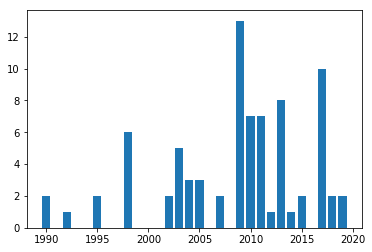

In [150]:
def reformat_for_simple_graph(result):
    x_values = [] # empty list to store x and y axis values
    y_values = []
    result_dict = {}
    for row in result:
        x_value = row
        y_value = len(result.get(row))
        #add to the result
        result_dict[x_value] = y_value
    # sort the results so the graph has an order
    for key in sorted(result_dict.keys()):
        x_values.append(key)
        y_values.append(result_dict[key])
    return x_values, y_values

x_values, y_values = reformat_for_simple_graph(ret)

# make a bar graph
plt.bar(x_values, y_values)


Try changing the search again above and then plotting each result.

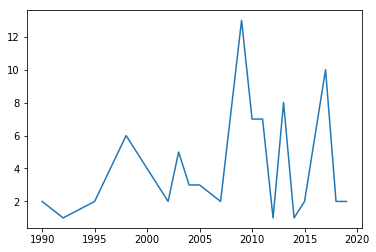

In [151]:
# make a line graph
plt.plot(x_values, y_values)

## 7) searching for two terms at once

It would be interesting to see how many PDB entries were solved by each experimental method per year. 

we can use the tag "release_year" to get the year of release of each entry

We have to define a new function to group entries by two terms.

In [152]:
def dual_result_counter(results, term1, term2):
    pdb_list = [] # we will use this to store the PDB IDs we have already seen so we don't double count
    ret = {} # the actual results

    # we will loop through the results and store the PDB codes associated with each result
    for result in results:
        term1_data = result.get(term1, '')
        term2_data = result.get(term2, '')
        if term1_data and term2_data:  # we have to check that both terms exists
            # change the results into a text string
            if type(term1_data) == list:
                term1_data = ','.join(sorted(term1_data))
            if type(term2_data) == list:
                term2_data = ','.join(sorted(term2_data))
            
            pdb_id = result.get('pdb_id')
            if pdb_id in pdb_list:
                continue # we have already seen this PDB code, move on to the next result
                
            # this time we will store the data in a nested dictionary
            ret.setdefault(term1_data, {}).setdefault(term2_data, []).append(pdb_id) # add pdb_id to a list for each experimental method
            pdb_list.append(pdb_id)
    return ret


def count_dual_results(result):
    for term1 in sorted(result.keys()):
        for term2 in result.get(term1):
            print('{}, {}: {} entries'.format(term1, term2, len(result.get(term1).get(term2))))

def reformat_for_multi_graph(ret):
    return_dict = {}
    # sort term 1 was it is in order
    term1_list = sorted(ret.keys())
    term2_dict = {}
    for key in ret:
        term2_keys = ret[key].keys()
        for term2 in term2_keys:
            # make a list as long as term1
            term2_dict[term2] = [0] * len(term1_list)
    
    for position, key in enumerate(ret):
        for term2 in term2_dict:
            # update the term 2 dicionary with the values to plot
            term2_dict[term2][position] = len(ret[key].get(term2, []))
    
    return_dict['x_axis'] = term1_list
    return_dict['y_axes'] = term2_dict
    return return_dict


Putting this all together in one section - in 4 lines we can search the whole PDB for Human Dihydrofolate reductase's and find out when they were released and which experimental method was used. 

In [153]:
search_terms = {"molecule_name":"Dihydrofolate reductase",
                "organism_name":"Human"
               } 
results = run_search(search_terms, number_of_rows=10000)
ret = dual_result_counter(results, term1='release_year', term2='experimental_method')
count_dual_results(ret)

https://www.ebi.ac.uk/pdbe/search/pdb/select?q=molecule_name:"Dihydrofolate reductase" AND organism_name:Human&wt=json&rows=10000
1990, X-ray diffraction: 2 entries
1992, X-ray diffraction: 1 entries
1995, X-ray diffraction: 2 entries
1998, X-ray diffraction: 6 entries
2002, X-ray diffraction: 2 entries
2003, X-ray diffraction: 5 entries
2004, X-ray diffraction: 3 entries
2005, Solution NMR: 1 entries
2005, X-ray diffraction: 2 entries
2007, X-ray diffraction: 2 entries
2009, X-ray diffraction: 13 entries
2010, X-ray diffraction: 7 entries
2011, X-ray diffraction: 7 entries
2012, X-ray diffraction: 1 entries
2013, X-ray diffraction: 8 entries
2014, X-ray diffraction: 1 entries
2015, X-ray diffraction: 2 entries
2017, X-ray diffraction: 10 entries
2018, X-ray diffraction: 2 entries
2019, X-ray diffraction: 2 entries


Try editing the search terms and see what you get.

## 8) Plotting the dual result

We can make these results look a bit more interesting by plotting them in a graph.

The graph we are going to plot has year on the X axis, number of PDB entries on the Y axis and then a line plot per experimental method.
We are also automatically adding a legend based on the y_axes dictionary.


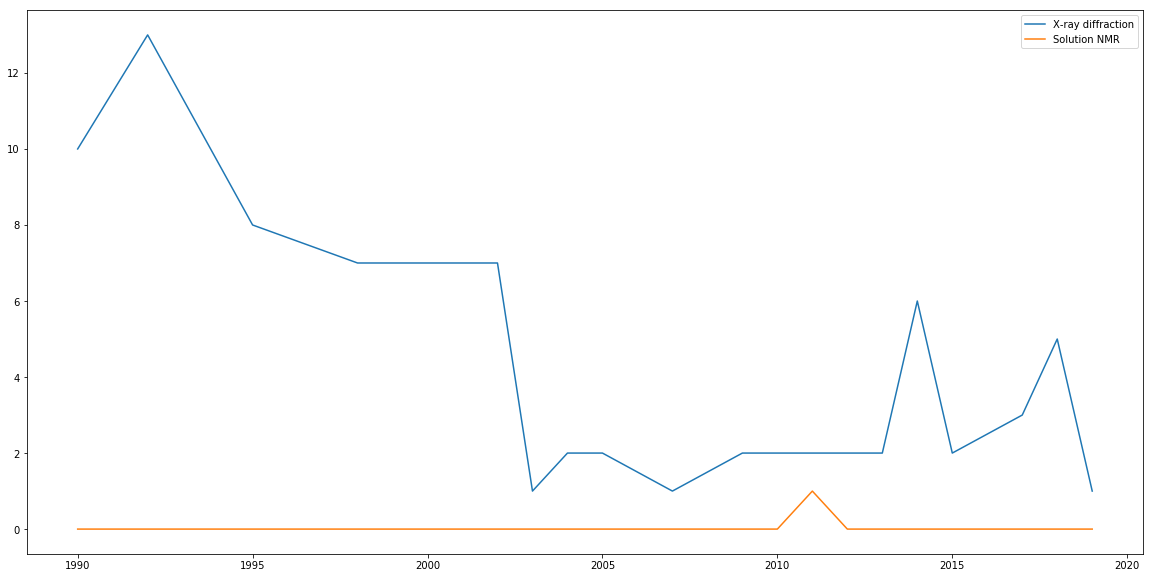

In [155]:
def plot_multi_line(input_dict):
    x_axis = input_dict['x_axis']
    y_axes = input_dict['y_axes']
    
    plt.figure(figsize=(20,10))

    
    for y in y_axes:
        plt.plot(x_axis, y_axes[y], label=y)
    plt.legend()
    plt.show()
results_for_graph = reformat_for_multi_graph(ret)
plot_multi_line(results_for_graph)

Try editing the queries and plotting new graphs.